The MIT License (MIT)

Copyright © 2026 Martin Ladecký, Ivana Pultarová, François Bignonnet, Indre Jödicke, Jan Zeman, Lars Pastewka

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Effect of zero in J-FFT
 This example demonstrates that convergence is independent of the auxiliary values in the Jacobi preconditioner. For voids or very compliant materials, the system matrix contains zeros on the diagonal. Therefore, the Jacobi preconditioner requires inverting zero. We avoid this by using a fallback value instead.

Key features:
1. **Jacobi Fallback Exploration**: Analyzing the effect of the fallback value in the Jacobi preconditioner across a wide range ($10^{-15}$ to $10^{15}$).
2. **Robustness Test**: Evaluating solver convergence on both sharp and smoothed microstructure geometries at high phase contrast ($10^{16}$).
3. **Comparative Visualization**: Plotting iteration counts and residual norms.

## Required Files
- `auxetic_microstructure_64.npy`: NumPy array containing the auxetic microstructure geometry (64×64 grid)

## Reference
This notebook accompanies the paper "Jacobi-accelerated FFT-based solver for smooth high-contrast data" and

In [28]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline


## Utility Functions



In [29]:
def get_shape_function_gradients(discretization_type, pixel_size):
    """
    Returns the shape function gradients and quadrature weights for a single pixel.
    Currently supports 'linear_triangles'.
    """
    if discretization_type == 'linear_triangles':
        ndim = 2
        nb_quad = 2
        dx, dy = pixel_size
        # B(dim, quad_point, node_idx)
        B = np.zeros([ndim, nb_quad, 4])
        # first quad point
        B[:, 0, :] = [[-1 / dx, 0, 1 / dx, 0],
                      [-1 / dy, 1 / dy, 0, 0]]
        # second quad point
        B[:, 1, :] = [[0, -1 / dx, 0, 1 / dx],
                      [0, 0, -1 / dy, 1 / dy]]

        weights = np.array([dx * dy / 2, dx * dy / 2])
        return B.reshape(ndim, nb_quad, 2, 2), weights

def get_gradient_operators(pixel_size, N, dofs_per_node):
    """
    Creates and returns the gradient (B) and weighted divergence (Bw_t) operators
    for the given grid and discretization.
    """
    ndim = 2
    B_dqij, weights = get_shape_function_gradients('linear_triangles', pixel_size)
    nb_quad = weights.size

    def B_op(u_ixy):
        grad_u_ijqxy = np.zeros([dofs_per_node, ndim, nb_quad, *N])
        for pixel_node in np.ndindex(2, 2):
            grad_u_ijqxy += np.einsum('jq,ixy...->ijqxy...',
                                      B_dqij[(..., *pixel_node)],
                                      np.roll(u_ixy, -1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1))),
                                      optimize='optimal')
        return grad_u_ijqxy

    def Bw_t_op(flux_ijqxyz):
        div_flux_ixy = np.zeros([dofs_per_node, *N])
        # apply quadrature weights
        flux_weighted = np.einsum('ijq...,q->ijq...', flux_ijqxyz, weights, optimize='optimal')
        for pixel_node in np.ndindex(2, 2):
            div_fnxyz_pixel_node = np.einsum('jq,ijqxy...->ixy...',
                                             B_dqij[(..., *pixel_node)],
                                             flux_weighted, optimize='optimal')
            div_flux_ixy += np.roll(div_fnxyz_pixel_node, 1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1)))
        return div_flux_ixy

    return B_op, Bw_t_op, weights

def scale_field_log10(field, min_val, max_val):
    """Logarithmically scales a field to be within [min_val, max_val]."""
    field_log = np.log10(field)
    field_min, field_max = np.min(field_log), np.max(field_log)
    # Normalize to [0,1]
    scaled_field = (field_log - field_min) / (field_max - field_min)
    # Scale to target log range and exponentiate
    return 10 ** (scaled_field * (np.log10(max_val) - np.log10(min_val)) + np.log10(min_val))


## Problem Parameters
Setup grid, loading, and material properties.


In [26]:

nb_quad_points_per_pixel = 2
ndim = 2
N_x = N_y = 64
N = (N_x, N_y)
domain_size = (1, 1)
domain_vol = np.prod(domain_size)
pixel_size = tuple(np.array(domain_size) / np.array(N))

# Load auxetic microstructure geometry
name = 'auxetic_microstructure_64'
try:
    geometry = np.load(f'./{name}.npy', allow_pickle=True)
except FileNotFoundError:
    try:
        geometry = np.load(f'../data/{name}.npy', allow_pickle=True)
    except FileNotFoundError:
        # Fallback for different execution environments
        import os
        geometry = np.load(os.fspath(os.path.join('experiments/Paper:Jacobi-accelerated FFT/', f'{name}.npy')), allow_pickle=True)

# Auxiliary values
n_u_dofs = ndim
ndof = ndim * np.prod(np.array(N))
displacement_shape = (ndim,) + N
grad_shape = (ndim, ndim, nb_quad_points_per_pixel) + N

# Basic operators
dot21 = lambda A, v: np.einsum('ij...,j...->i...', A, v)
ddot42 = lambda A, B: np.einsum('ijkl...,lk...->ij...', A, B)
fft = lambda x: np.fft.fftn(x, [*N])
ifft = lambda x: np.fft.ifftn(x, [*N])

# Initialize gradient operators
B, Bw_t, quadrature_weights = get_gradient_operators(pixel_size, N, n_u_dofs)

# Define reference elasticity tensors
i_mat = np.eye(ndim)
I4s = (np.einsum('il,jk', i_mat, i_mat) + np.einsum('ik,jl', i_mat, i_mat)) / 2.
II = np.einsum('ij,kl', i_mat, i_mat)

K_0, mu_0 = 1.0,  0.5  # Bulk and shear modulus for matrix
K4_0 = K_0 * II + 2. * mu_0 * (I4s - 1. / 3. * II) # Stiffness tensor

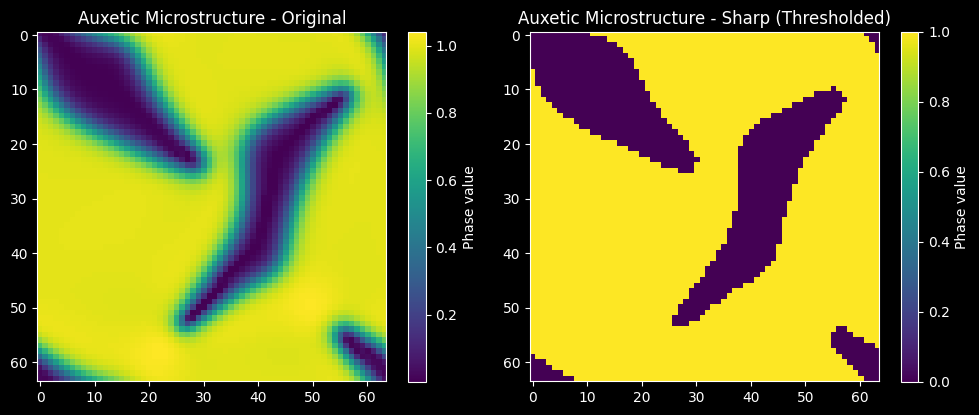

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(geometry), cmap='viridis')
plt.colorbar(label='Phase value')
plt.title('Auxetic Microstructure - Original')

plt.subplot(1, 2, 2)
sharp_geom = np.abs(geometry).copy()
sharp_geom[sharp_geom < 0.5] = 0
sharp_geom[sharp_geom >= 0.5] = 1
plt.imshow(sharp_geom, cmap='viridis')
plt.colorbar(label='Phase value')
plt.title('Auxetic Microstructure - Sharp (Thresholded)')

plt.tight_layout()
plt.show()

## Simulation Loop
Iterate over a range of Jacobi fallback values and evaluate solver convergence.


Val Jacobi 1.0e-15, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e-15, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e-10, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e-10, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e-05, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e-05, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e+00, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e+00, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e+05, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e+05, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e+10, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e+10, sharp=False: G=1000, J=470, GJ=139
Val Jacobi 1.0e+15, sharp=True: G=35, J=445, GJ=152
Val Jacobi 1.0e+15, sharp=False: G=1000, J=470, GJ=139


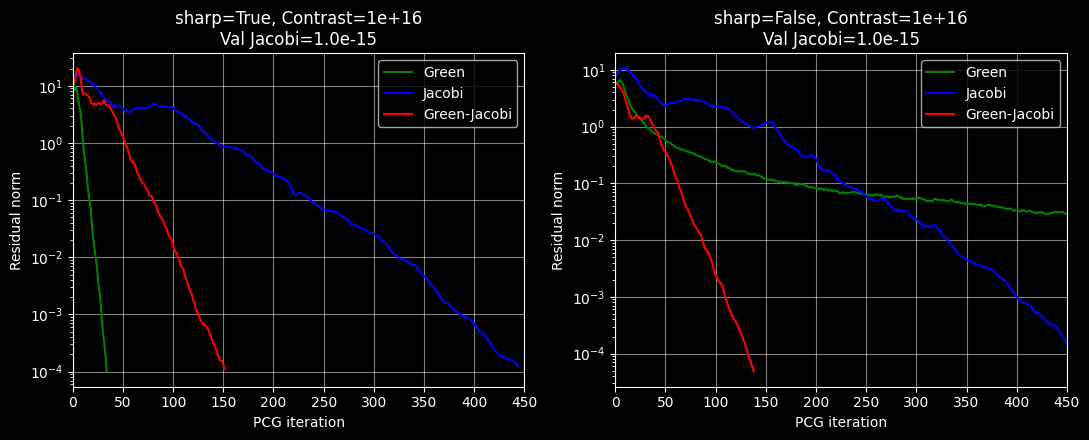

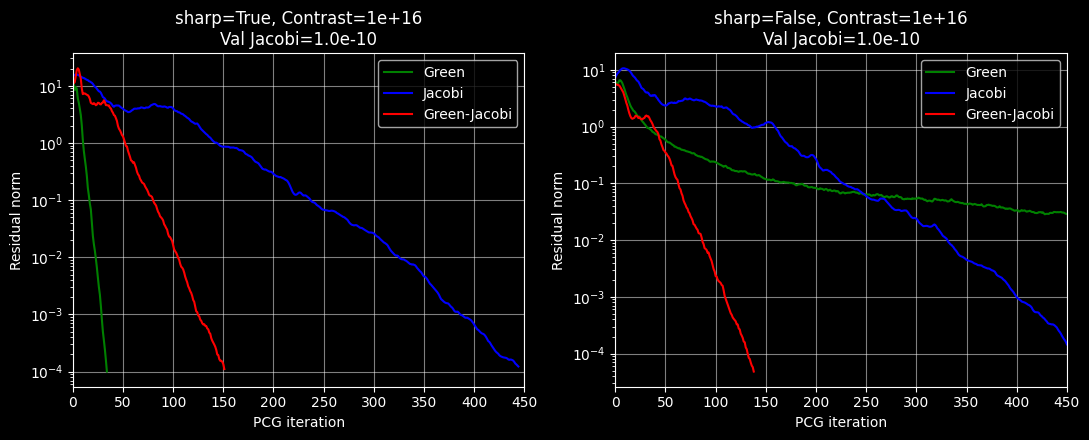

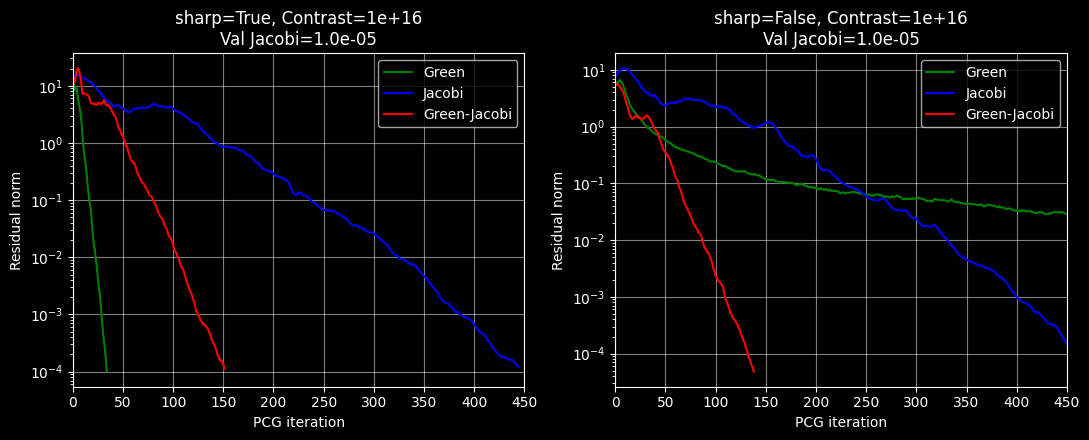

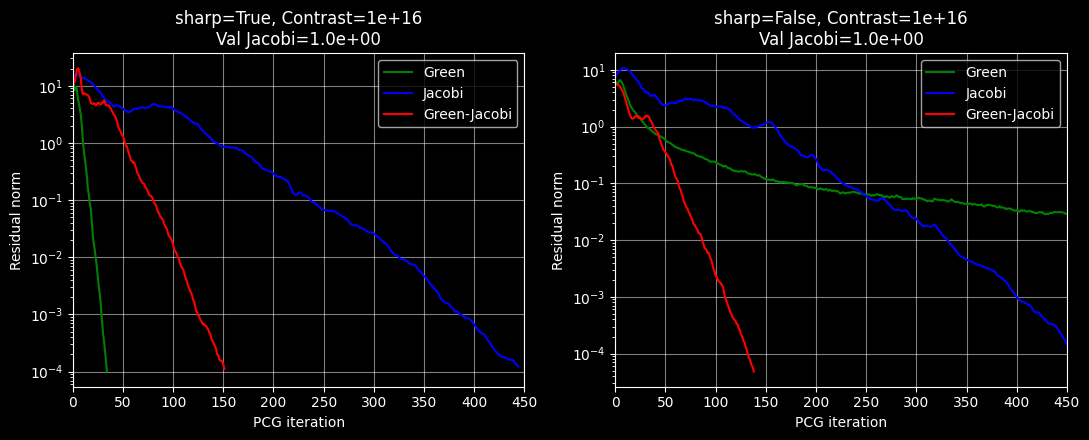

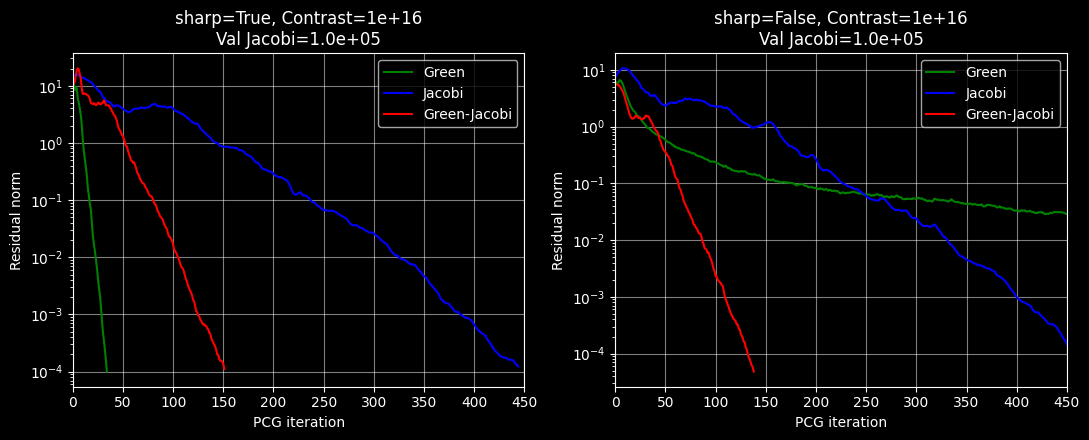

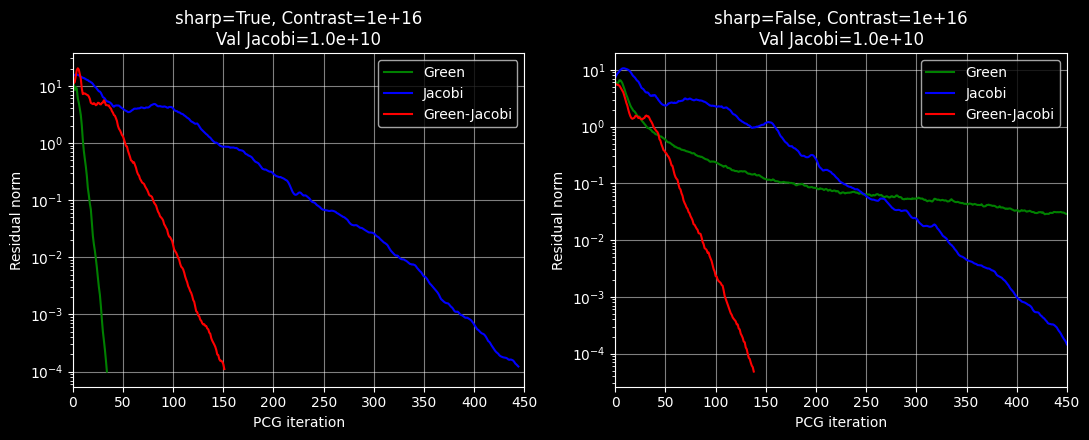

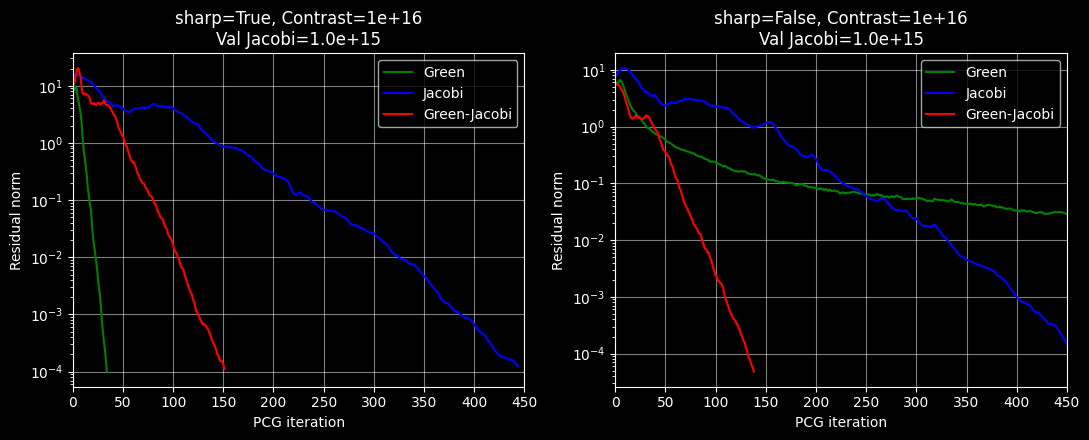

In [24]:
# Loop over different fallback values for the Jacobi preconditioner
fallback_values = np.logspace(-15, 15, 7)
nb_it_GJ_sharp = []
nb_it_GJ_smooth = []

for value_jacobi in fallback_values:
    total_phase_contrast_list = [1e16]
    fig = plt.figure(figsize=(11, 4.5))
    gs = fig.add_gridspec(1, 2)
    plot_col = 0

    for sharp in [True, False]:
        nb_it_G = []
        nb_it_J = []
        nb_it_GJ = []
        
        for total_phase_contrast in total_phase_contrast_list:
            # Initialize phase field from geometry
            phase = np.ones([nb_quad_points_per_pixel, N_x, N_y])
            phase[:, ...] = np.abs(geometry)

            # Apply sharp transition if requested
            if sharp:
                phase = np.where(phase < 0.5, 1 / total_phase_contrast, 1.0)
            else:
            # Scale field logarithmically with robust bounds
                phase = scale_field_log10(field=np.copy(phase),
                                          min_val=min(1.0, 1 / total_phase_contrast),
                                          max_val=max(1.0, 1 / total_phase_contrast))



            # Update material data
            mat_data_ijklqxy = np.einsum('ijkl,qxy...', K4_0, phase)

            # Macroscopic loading (strain in XX direction)
            macro_grad_ij = np.zeros([n_u_dofs, ndim])
            macro_grad_ij[0, 0] = 1
            E_ijqxy = np.zeros(grad_shape)
            E_ijqxy += macro_grad_ij[(slice(None), slice(None)) + (np.newaxis,) * (len(E_ijqxy.shape) - 2)]

            # Define system matrix operator K(u) and RHS vector b
            K_fun_I = lambda x: Bw_t(ddot42(mat_data_ijklqxy, B(u_ixy=x.reshape(displacement_shape)))).reshape(-1)
            b_I = -Bw_t(ddot42(A=mat_data_ijklqxy, B=E_ijqxy)).reshape(-1)

            # --- Preconditioners ---

            # 1. Green's Preconditioner
            ref_mat_data_ijkl = K4_0
            K_ref_fun = lambda x: Bw_t(ddot42(ref_mat_data_ijkl, B(u_ixy=x.reshape(displacement_shape))))

            G_diag_ijxy = np.zeros([n_u_dofs, n_u_dofs, *N])
            for d in range(n_u_dofs):
                unit_impuls_ixy = np.zeros(displacement_shape)
                unit_impuls_ixy[(d,) + ndim * (0,)] = 1
                G_diag_ijxy[:, d, ...] = K_ref_fun(x=unit_impuls_ixy)

            G_diag_ijxy = np.real(fft(x=G_diag_ijxy))
            reshaped_matrices = G_diag_ijxy.reshape(n_u_dofs, n_u_dofs, -1)
            G_batch = reshaped_matrices.transpose(2, 0, 1)
            # Invert blocks in Fourier space
            G_batch[1:, ...] = np.linalg.inv(G_batch[1:, ...])
            M_diag_ijxy = G_batch.transpose(1, 2, 0).reshape(n_u_dofs, n_u_dofs, *N)
            Green_fun_I = lambda x: np.real(ifft(dot21(M_diag_ijxy, fft(x=x.reshape(displacement_shape))))).reshape(-1)

            # 2. Jacobi Preconditioner
            Jacobi_diag_ixy = np.zeros([n_u_dofs, *N])
            for d_i in range(ndim):
                for x_i in range(2):
                    for y_i in range(2):
                        comb_impuls_ixy = np.zeros(displacement_shape)
                        comb_impuls_ixy[d_i, x_i::2, y_i::2] = 1.0
                        comb_impuls_ixy = K_fun_I(x=comb_impuls_ixy).reshape(displacement_shape)
                        
                        # Apply fallback 'value_jacobi' where diagonal is zero
                        Jacobi_diag_ixy[d_i, x_i::2, y_i::2] = np.where(
                            comb_impuls_ixy[d_i, x_i::2, y_i::2] != 0.,
                            1 / np.sqrt(comb_impuls_ixy[d_i, x_i::2, y_i::2]), value_jacobi)

            Jacobi_fun = lambda x: Jacobi_diag_ixy * Jacobi_diag_ixy * x.reshape(displacement_shape)

            # 3. Green-Jacobi Preconditioner
            GreenJacobi_fun = lambda x: (Jacobi_diag_ixy * Green_fun_I(Jacobi_diag_ixy * x.reshape(displacement_shape)).reshape(displacement_shape))

            # --- Solvers ---

            # Solver with Green Preconditioner
            res_G = []
            def cb_G(xk): res_G.append(np.linalg.norm(b_I - K_fun_I(xk)))
            _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), Green_fun_I), atol=1e-6, callback=cb_G, maxiter=1000)
            nb_it_G.append(len(res_G))

            # Solver with Jacobi Preconditioner
            res_J = []
            def cb_J(xk): res_J.append(np.linalg.norm(b_I - K_fun_I(xk)))
            _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), Jacobi_fun), atol=1e-6, callback=cb_J, maxiter=1000)
            nb_it_J.append(len(res_J))

            # Solver with Green-Jacobi Preconditioner
            res_GJ = []
            def cb_GJ(xk): res_GJ.append(np.linalg.norm(b_I - K_fun_I(xk)))
            _, _ = sc.sparse.linalg.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), GreenJacobi_fun), atol=1e-6, callback=cb_GJ, maxiter=1000)
            nb_it_GJ.append(len(res_GJ))

            # Plot residuals for current 'sharp' setting
            ax0 = fig.add_subplot(gs[0, plot_col])
            ax0.semilogy(res_G, label='Green', color='g',  markevery=max(1, len(res_G)//10))
            ax0.semilogy(res_J, label='Jacobi', color='b')
            ax0.semilogy(res_GJ, label='Green-Jacobi', color='r')
            
            ax0.set_title(f'sharp={sharp}, Contrast={total_phase_contrast:.0e}\nVal Jacobi={value_jacobi:.1e}')
            ax0.set_xlabel('PCG iteration')
            ax0.set_ylabel('Residual norm')
            ax0.set_xlim([0,450])

            ax0.legend()
            ax0.grid(True, which="major", ls="-", alpha=0.5)

            plot_col += 1
            print(f'Val Jacobi {value_jacobi:.1e}, sharp={sharp}: G={len(res_G)}, J={len(res_J)}, GJ={len(res_GJ)}')
            if sharp:
                nb_it_GJ_sharp.append(len(res_GJ))
            else:
                nb_it_GJ_smooth.append(len(res_GJ))
    
    plt.tight_layout()
    plt.savefig(f'../figures/variable_jacobi_fallback_val_{value_jacobi:.1e}.png')
    #plt.show()

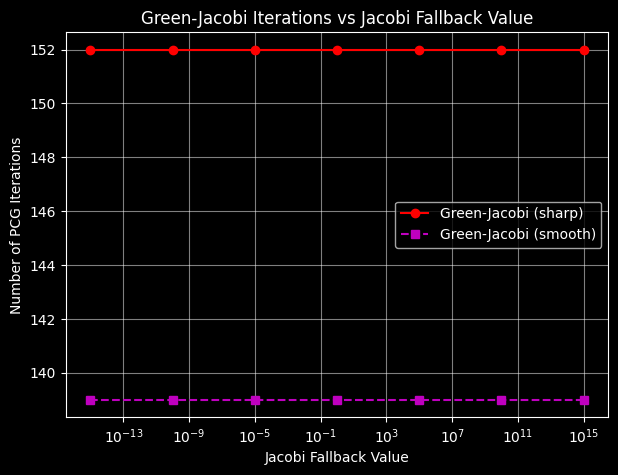

In [25]:
# Plot iterations vs Jacobi fallback value
plt.figure(figsize=(7, 5))
plt.semilogx(fallback_values, nb_it_GJ_sharp, 'o-', label='Green-Jacobi (sharp)', color='r')
plt.semilogx(fallback_values, nb_it_GJ_smooth, 's--', label='Green-Jacobi (smooth)', color='m')
plt.title('Green-Jacobi Iterations vs Jacobi Fallback Value')
plt.xlabel('Jacobi Fallback Value')
plt.ylabel('Number of PCG Iterations')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig('../figures/nb_it_GJ_vs_fallback.png')
plt.show()